Coupling map:


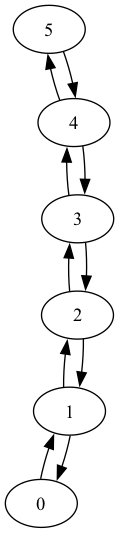

In [1]:
from spillover_effect_on_subsystem import (
    LocalSpilloverNoiseAerPass,
    circuit_context,
    numpy_to_hashable,
    noisy_backend,
)
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.transpiler import PassManager, CouplingMap
import numpy as np
import matplotlib.pyplot as plt

num_qubits = 6
rotation_axes = ["rx", "rx", "rx", "rx", "rx", "rx"]
rotation_parameters = [Parameter(f"ϕ_{i}") for i in range(num_qubits)]
cm = CouplingMap.from_line(num_qubits, True)
print("Coupling map:")
cm.draw()

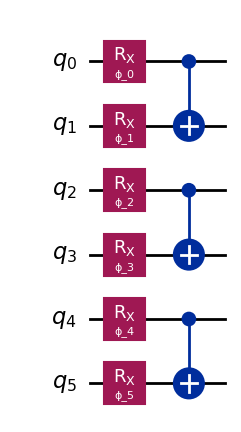

In [2]:
circuit = circuit_context(
    num_qubits, rotation_axes, rotation_parameters, coupling_map=cm
)
circuit.draw("mpl")

Parameter dictionary:
 {Parameter(ϕ_0): 4.665466064857704, Parameter(ϕ_1): 3.4958331672967256, Parameter(ϕ_2): 1.1607433119572852, Parameter(ϕ_3): 3.9246618340416872, Parameter(ϕ_4): 0.8148633976847353, Parameter(ϕ_5): 6.110646020345377}


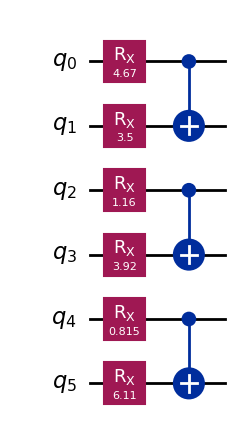

In [3]:
seed = 20983
np.random.seed(seed)
rotation_angles = np.random.uniform(0, 2 * np.pi, num_qubits)
# rotation_angles = np.array([0.0, 0.0, np.pi, 0., 0.0, 0.0])
param_dict = {theta: val for theta, val in zip(rotation_parameters, rotation_angles)}
print("Parameter dictionary:\n", param_dict)
circuit.assign_parameters(param_dict).draw("mpl")

/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


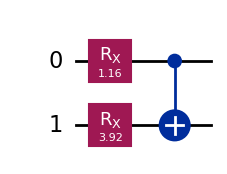

In [4]:
from rl_qoc.helpers import causal_cone_circuit

causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0].draw("mpl")

Text(0.5, 1.0, 'Spillover rate matrix')

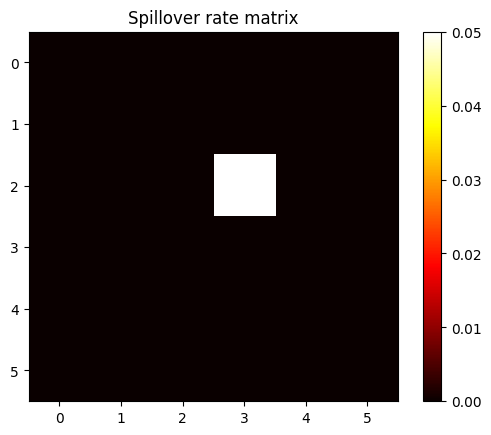

In [7]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 1] = 0.0  # γ_0->1
gamma_matrix[0, 3] = 0.0  # γ_0->3
gamma_matrix[1, 2] = 0.0  # γ_1->2
gamma_matrix[2, 2] = 0.0  # γ_2->2
gamma_matrix[2, 3] = 0.05  # γ_2->3
gamma_matrix[3, 2] = 0.0  # γ_3->2
gamma_matrix[4, 3] = 0.0  # γ_4->3
gamma_matrix[5, 4] = 0.0  # γ_5->4
# gamma_matrix = 0.05 * np.round(np.random.rand(num_qubits, num_qubits), 3)
# gamma_matrix = 0.05 * np.eye(num_qubits)
# Display gamma matrix with imshow plot for better visualization
plt.imshow(gamma_matrix, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Spillover rate matrix")

# Display gamma matrix as weights in a directed graph
# import networkx as nx
#
# G = nx.DiGraph(gamma_matrix)
# pos = nx.spring_layout(G)
# nx.draw(G, None, with_labels=True, node_size=1000, node_color="skyblue", font_size=10)
# labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
# plt.title("Spillover rate matrix as directed graph")

In [8]:
gamma_matrix

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.05, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

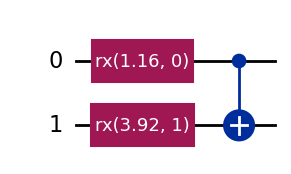

In [9]:
pass_ = LocalSpilloverNoiseAerPass(
    spillover_rate_matrix=numpy_to_hashable(gamma_matrix),
    target_subsystem=(2, 3),
)
pm = PassManager([pass_])
qc_noisy = causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0]
qc_noisy = pm.run(qc_noisy)
qc_noisy.draw("mpl")

In [10]:
qc_noisy.data

[CircuitInstruction(operation=Instruction(name='unitary', num_qubits=1, num_clbits=0, params=[array([[0.83625892+0.j        , 0.        -0.54833478j],
       [0.        -0.54833478j, 0.83625892+0.j        ]])]), qubits=(Qubit(QuantumRegister(6, 'q'), 2),), clbits=()), CircuitInstruction(operation=Instruction(name='unitary', num_qubits=1, num_clbits=0, params=[array([[-0.38160732+0.j        ,  0.        -0.92432454j],
       [ 0.        -0.92432454j, -0.38160732+0.j        ]])]), qubits=(Qubit(QuantumRegister(6, 'q'), 3),), clbits=()), CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3)), clbits=())]

In [11]:
backend = noisy_backend(
    circuit.assign_parameters(param_dict),
    gamma_matrix,
    target_subsystem=(2, 3),
)

In [12]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '44909d3bc8ad44c9bd501ed2428b69df',
   'operations': ['rx(3.92, 1)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.99957899+0.j        , 0.        -0.02901451j],
              [0.        -0.02901451j, 0.99957899+0.j        ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(1,)]}]}

In [13]:
from qiskit.transpiler import generate_preset_pass_manager

full_pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
custom_translation_pass = PassManager([pass_] + full_pm.translation._tasks[0])
full_pm.translation = custom_translation_pass

In [14]:
full_pm.translation._tasks

[[<spillover_effect_on_subsystem.LocalSpilloverNoiseAerPass at 0x1556f8790>,

In [15]:
print("Rotation angles:", rotation_angles)

Rotation angles: [4.66546606 3.49583317 1.16074331 3.92466183 0.8148634  6.11064602]


In [16]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '44909d3bc8ad44c9bd501ed2428b69df',
   'operations': ['rx(3.92, 1)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.99957899+0.j        , 0.        -0.02901451j],
              [0.        -0.02901451j, 0.99957899+0.j        ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(1,)]}]}

In [17]:
from qiskit.quantum_info import Operator

Operator(qc_noisy)

Operator([[-0.31912253+0.j        ,  0.        +0.20924857j,
            0.        -0.77297464j, -0.50683929+0.j        ],
          [-0.50683929+0.j        ,  0.        -0.77297464j,
            0.        +0.20924857j, -0.31912253+0.j        ],
          [ 0.        -0.77297464j, -0.50683929+0.j        ,
           -0.31912253+0.j        ,  0.        +0.20924857j],
          [ 0.        +0.20924857j, -0.31912253+0.j        ,
           -0.50683929+0.j        ,  0.        -0.77297464j]],
         input_dims=(2, 2), output_dims=(2, 2))


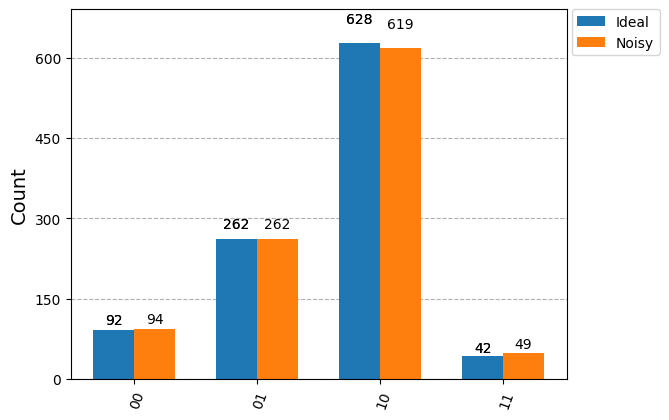

In [18]:
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

ideal_backend = AerSimulator()

ideal_result = ideal_backend.run(qc_noisy.measure_all(inplace=False)).result()
noisy_result = backend.run(qc_noisy.measure_all(inplace=False)).result()

ideal_counts = ideal_result.get_counts()
noisy_counts = noisy_result.get_counts()

plot_histogram([ideal_counts, noisy_counts], legend=["Ideal", "Noisy"])

In [19]:
# Compute fidelities
from qiskit.quantum_info import state_fidelity, average_gate_fidelity

qc_noisy_ideal_state = qc_noisy.copy()
qc_noisy_state = qc_noisy.copy()
# qc_noisy_ideal_state.save_statevector()
qc_noisy_ideal_state.save_unitary()
# qc_noisy_state.save_statevector()
qc_noisy_state.save_unitary()

# ideal_state = ideal_backend.run(qc_noisy_ideal_state).result().get_statevector()
# noisy_state = backend.run(qc_noisy_state).result().get_statevector()
ideal_unitary = ideal_backend.run(qc_noisy_ideal_state).result().get_unitary()
noisy_unitary = backend.run(qc_noisy_state).result().get_unitary()

In [20]:
output_fidelity = average_gate_fidelity(ideal_unitary, noisy_unitary)
output_fidelity

0.9993265265528055

In [21]:
from qiskit import QuantumRegister
from rl_qoc.helpers.circuit_utils import get_gate


# Add here custom ansatz CX gate


def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    # optimal_params = np.pi * np.zeros(len(params))
    new_params = [optimal_params[i] + params[i] for i in range(len(params))]

    my_qc.u(
        *new_params[:3],
        q_reg[0],
    )
    my_qc.u(
        *new_params[3:6],
        q_reg[1],
    )

    my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])

    qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

In [22]:
# Define the environment
from gymnasium.spaces import Box
from rl_qoc import (
    QEnvConfig,
    ExecutionConfig,
    ContextAwareQuantumEnvironment,
    RescaleAndClipAction,
)
from rl_qoc.environment.configuration.backend_config import QiskitConfig
from arbitrary_angle_spillover_env import (
    ArbitraryAngleSpilloverEnv,
)
# from gate_level.spillover_noise_use_case.generic_spillover.local_spillover_env import (
#     LocalSpilloverEnvironment,
# )

env_metadata = {
    "γ": gamma_matrix,
    "target_subsystem": (2, 3),
    "rotation_axes": rotation_axes,
    "num_qubits": num_qubits,
    "rotation_parameters": rotation_parameters,
    "seed": seed,
}

action_space = Box(low=-0.5, high=0.5, shape=(7,), dtype=np.float32)
target = {"gate": "cnot", "physical_qubits": [2, 3]}

backend_config = QiskitConfig(
    apply_parametrized_circuit,
    backend=backend,
    skip_transpilation=False,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
    pass_manager=full_pm,
)
q_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=32,
        n_reps=[7,],
        n_shots=10,
        sampling_paulis=100,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="channel",
    env_metadata=env_metadata,
)
# q_env = LocalSpilloverEnvironment(
#     q_env_config,
#     circuit_context=circuit.assign_parameters(param_dict),  # Pass the circuit already transpiled through custom pass
# )
q_env = ArbitraryAngleSpilloverEnv(
    q_env_config, unbound_circuit_context=circuit, gamma_matrix=gamma_matrix
)

/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [23]:
from typing import Optional, Dict, Any, SupportsFloat
from rl_qoc.environment.context_aware_quantum_environment import ObsType, ActType

class OneParamAngleSpilloverEnv(ContextAwareQuantumEnvironment):
    """
    Quantum environment with spillover noise on a subsystem where each epoch will have a random set of angles.
    The input circuit context of this environment is expected to have symbolic Parameters for all rotation axes.
    It also should have the form of one layer of single qubit rotation gates (rx, ry, rz) and a layer of two-qubit gates.
    Binding of those parameters will be done automatically at the reset of the environment.
    """

    def __init__(
        self,
        q_env_config: QEnvConfig,
        unbound_circuit_context: QuantumCircuit,
        gamma_matrix: np.ndarray,
        num_params,
        discrete_history_length,
        circuit_param_distribution: Optional[str] = "uniform",
        optimal_error_precision: Optional[float] = 1e-4,
    ):
        """
        Initialize the environment
        """
        self.num_params = num_params
        self.circuit_param_distribution = circuit_param_distribution
        self.optimal_error_precision = optimal_error_precision
        self.discrete_history_length = discrete_history_length
        self.gamma_matrix = gamma_matrix
        self.circuit_parameters = unbound_circuit_context.parameters

        super().__init__(q_env_config, unbound_circuit_context)
        self._rotation_angles_rng = np.random.default_rng(
            self.np_random.integers(2**32)
        )
        self.observation_space = Box(
            low=np.array([-np.pi] * 1),
            high=np.array([np.pi] * 1),
            dtype=np.float64,
        )

        self.discrete_reward_history = np.ones((discrete_history_length, self.num_params))
        self.discrete_obs_vals = np.linspace(
            self.observation_space.low, self.observation_space.high, self.num_params
        ).flatten()
        print(f"Observation Vals: {self.discrete_obs_vals}")
        self.obs_angles = np.zeros(self.observation_space.shape)

    def define_target_and_circuits(self):
        """
        Define the target gate and the circuits to be executed
        """
        circuit_context = causal_cone_circuit(
            self.circuit_context, list(self.config.env_metadata["target_subsystem"])
        )[0]
        self._physical_target_qubits = list(range(circuit_context.num_qubits))
        self._circuit_context = circuit_context
        target, custom_circuits, baseline_circuits = (
            super().define_target_and_circuits()
        )

        return target, custom_circuits, baseline_circuits

    def reset(
        self,
        debug_obs: Optional[np.ndarray] = None,
        *,
        seed: Optional[int] = None,
        options: Optional[Dict[str, Any]] = None,
    ) -> tuple[ObsType, dict[str, Any]]:
        """
        Reset the environment
        :param seed: Seed for the environment
        :param options: Options for the environment
        :return: Initial observation and info
        """

        # Reset the environment
        old_angles, info = super().reset(seed=seed, options=options)

        if debug_obs is not None:
            self.obs_angles = debug_obs
        else:
            self.obs_angles = self._get_new_angles()

        phi = np.zeros(self.unbound_circuit_context.num_qubits)
        phi[2] = self.obs_angles[0]
        # phi[3] = self.obs_angles[0]

        param_dict = {self.circuit_parameters[i].name: phi[i] for i in range(len(phi))}
        circuit = self.unbound_circuit_context.assign_parameters(param_dict)
        backend = noisy_backend(
            circuit, self.gamma_matrix, self.config.env_metadata["target_subsystem"]
        )
        # Generate the initial observation
        self.set_circuit_context(None, backend=backend, **param_dict)
        env_obs = self._get_obs()
        print("Sampled angles: ", phi)
        print(f"Environment Observation: {env_obs}")
        # Return the initial observation and info
        return env_obs, {}
    
    def _get_new_angles(self):
        if self.circuit_param_distribution == "uniform":
            angles = np.random.uniform(
                self.observation_space.low, self.observation_space.high, self.observation_space.shape
            )
        if self.circuit_param_distribution == "simple_discrete":
            self.prob_weights = np.ones_like(self.discrete_obs_vals)
            self.prob_weights /= np.sum(self.prob_weights)
            angles = np.random.choice(
                a=self.discrete_obs_vals, 
                size=len(self.observation_space.shape), 
                p=self.prob_weights,
                replace=True
            )
        if self.circuit_param_distribution == "moving_discrete":
            self.prob_weights = (np.mean(
                self.discrete_reward_history, axis=0
            ) + np.log10(self.optimal_error_precision)) ** 2
            self.prob_weights /= np.sum(self.prob_weights)
            angles = np.random.choice(
                a=self.discrete_obs_vals, 
                size=len(self.observation_space.shape), 
                replace=True,
                p=self.prob_weights
            )
        return angles
    
    def step(
        self, action: ActType
    ) -> tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]:

        print(f"batch action shape: {action.shape}")
        
        obs, reward, terminated, truncated, info = super().step(action)
        print(f"obs: {obs}")
        print(f"reward: {reward}")

        self.update_discrete_history(reward, obs)

        return obs, reward, terminated, truncated, info
    
    def update_discrete_history(self, reward, obs):
        obs_ind = np.argmin(np.abs(self.discrete_obs_vals - obs * np.pi))
        self.discrete_reward_history[:, obs_ind] = np.append(
            [np.mean(reward)], self.discrete_reward_history[:-1, obs_ind], axis=0
        )
    
    # def initialize_discrete_history(self):
    #     # Initializes Discrete History with success of zeros policy
    #     for set_obs in np.tile(self.discrete_obs_vals, (self.discrete_history_length,)):
    #         _obs, info = self.reset(debug_obs=np.array([set_obs]))
    #         obs, reward, terminated, truncated, info = self.step(np.zeros((self.batch_size,) + self.action_space.shape))
    
    def clear_history(self):
        super().clear_history()
        self.discrete_reward_history = np.ones_like(self.discrete_reward_history)

    def _get_obs(self):
        """
        Get the observation
        :return: Observation
        """
        return self.obs_angles / np.pi # Normalized to multiples of pi

    def _get_info(self) -> Any:
        return {}

In [24]:
alt_q_env = OneParamAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix, 
    num_params=17,
    discrete_history_length=3,
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-5
)

Observation Vals: [-3.14159265 -2.74889357 -2.35619449 -1.96349541 -1.57079633 -1.17809725
 -0.78539816 -0.39269908  0.          0.39269908  0.78539816  1.17809725
  1.57079633  1.96349541  2.35619449  2.74889357  3.14159265]


In [25]:
rescaled_q_env = RescaleAndClipAction(alt_q_env, min_action=-1., max_action=1.)

In [24]:
rescaled_q_env.action_space

Box(-0.3, 0.3, (7,), float32)

In [25]:
rescaled_q_env.action_space.low

array([-0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3], dtype=float32)

In [26]:
rescaled_q_env.action_space.high

array([0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3], dtype=float32)

In [27]:
print(alt_q_env.batch_size)

32


In [28]:
# Testing n-reps fitting

from typing import Callable, Any, Optional, List, Literal
from scipy.optimize import curve_fit

def _fit_function(n, eps_quad):
    return 3/5 + 2/5 * np.cos(n * eps_quad)

def _fit_function_2(n, delta_1, delta_2):
    return (4 * np.cos(n * delta_1)**2 * np.cos(n * delta_2)**2 + 1) / 5

def _inverse_fit_function(reward, n, spam, eps_lin, eps_quad):
    return reward + eps_lin * (n - 1) + eps_quad * (n**2 - 1)

def custom_reward_fit(
    env,
    params: np.array,
    execution_config: Optional[ExecutionConfig] = None,
    fit_function: Optional[Callable] = None,
    inverse_fit_function: Optional[Callable] = None,
    update_fit_params: bool = True,
    reward_method: Optional[
        Literal["cafe", "channel", "orbit", "state", "xeb", "fidelity"]
    ] = None,
) -> plt.Figure:
    """
    Method to fit the initial reward function to the first set of actions in the environment
    with respect to the number of repetitions of the cycle circuit
    """

    initial_execution_config = env.config.execution_config
    initial_reward_method = env.config.reward_method
    if execution_config is not None:
        env.config.execution_config = execution_config
    if reward_method is not None:
        env.config.reward_method = reward_method
    reward_data = []
    for i in range(len(env.config.execution_config.n_reps)):
        env.config.execution_config.n_reps_index = i
        reward = env.perform_action(params, update_env_history=False)
        reward_data.append(np.mean(reward))
    if fit_function is None or inverse_fit_function is None:
        fit_function = _fit_function
        inverse_fit_function = _inverse_fit_function

    p0 = [0.015,]  # Initial guess for the parameters
    lower_bounds = [0.0,]
    upper_bounds = [10.,]

    popt, pcov = curve_fit(
        fit_function,
        env.config.execution_config.n_reps,
        reward_data,
        p0=p0,
        bounds=(lower_bounds, upper_bounds),
    )

    # Create a figure and return it to the user
    fig, ax = plt.subplots()
    ax.plot(
        env.config.execution_config.n_reps, reward_data, label="Data", marker="o"
    )
    ax.plot(
        env.config.execution_config.n_reps,
        [fit_function(n, *popt) for n in env.config.execution_config.n_reps],
        label="Fit",
    )
    ax.set_xlabel("Number of repetitions")
    ax.set_ylabel("Reward")
    ax.legend()
    ax.set_title("Initial reward fit (for varying number of repetitions)")
    # Print found parameters
    print("Found parameters:", popt)

    if execution_config is not None:
        env.config.execution_config = initial_execution_config
    if reward_method is not None:
        env.config.reward_method = initial_reward_method
    if update_fit_params:
        env._fit_function = lambda reward, n: inverse_fit_function(
            reward, n, *popt
        )
        env._fit_params = popt
    return fig, reward_data

Sampled angles:  [0.  0.  1.5 0.  0.  0. ]
Environment Observation: [0.47746483]
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.998875527244883
Reward (avg): 0.9989282518782614 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.998875527244883
Reward (avg): 0.9901146428920053 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.998875527244883
Reward (avg): 0.9722643889442988 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.998875527244883
Reward (avg): 0.9468082020059775 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.998875527244883
Reward (avg): 0.9147796331332725 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.998875527244883
Reward (avg): 0.8716991536495323 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fid

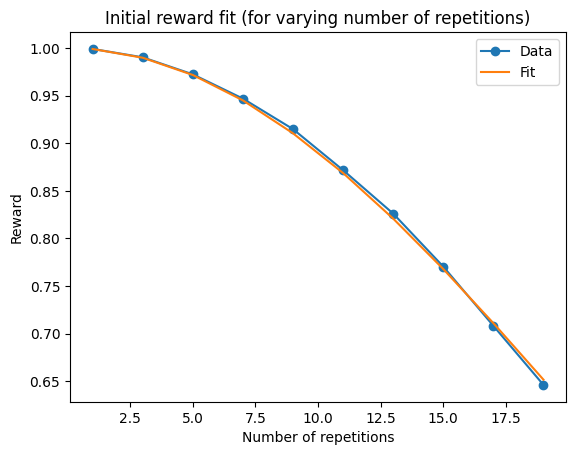

In [25]:
_obs, info = alt_q_env.reset(debug_obs=np.array([1.5]))

fig, reward_data = custom_reward_fit(  
    alt_q_env,
    np.zeros((1, 7)),
    ExecutionConfig(
        sampling_paulis=1000,
        n_shots=100,
        n_reps=list(
            range(1, 20, 2),
        ),
        dfe_precision=None,
        seed=q_env_config.seed,
        control_flow_enabled=False,
    ),
    update_fit_params=False,
    reward_method=None,
)

In [26]:
baseline_reward = []

alt_q_env.clear_history()
for set_obs in alt_q_env.discrete_obs_vals:
    # _obs, info = alt_q_env.reset(debug_obs=np.array([1.]))
    _obs, info = alt_q_env.reset(debug_obs=np.array([set_obs]))
    zero_action = np.zeros((alt_q_env.batch_size,) + alt_q_env.action_space.shape)
    print(zero_action.shape)
    obs, reward, terminated, truncated, info = alt_q_env.step(zero_action)
    baseline_reward.append(np.mean(reward))
    print(f"discrete reward history: {alt_q_env.discrete_reward_history}")

Sampled angles:  [ 0.          0.         -3.14159265  0.          0.          0.        ]
Environment Observation: [-1.]
(32, 7)
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9950753362380551
Reward (avg): 0.8004671717141392 Std: 0.010489967620198456
obs: [-1.]
reward: [0.69943287 0.71128808 0.71669549 0.67820983 0.73432075 0.72879825
 0.7225519  0.70918255 0.73532715 0.70624817 0.67642456 0.69581643
 0.67529934 0.66818621 0.72029374 0.66576477 0.67508958 0.69509924
 0.69148662 0.70513556 0.71863968 0.68993655 0.67144156 0.68677181
 0.73555284 0.69250305 0.71227423 0.67294287 0.6935294  0.7586952
 0.67448717 0.70160705]
discrete reward history: [[0.70059477 1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.      

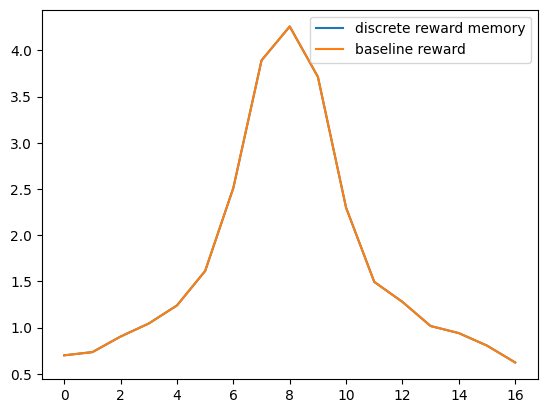

In [27]:
plt.plot(alt_q_env.discrete_reward_history[0], label='discrete reward memory')
plt.plot(baseline_reward, label='baseline reward')
plt.legend()
plt.show()

In [28]:
# PPO Details

from ppo_cleanrl import PPO_CleanRL

alt_q_env = OneParamAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix, 
    num_params=17,
    discrete_history_length=3,
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-5
)

agent_config = {
    "exp_name": "Test PPO CleanRL",
    "seed": 1,
    "torch_deterministic": True,
    "cuda": False,
    "track": False,
    "wandb_project_name": "Context Aware Calibrations",
    "wandb_entity": None,
    "save_model": True,
    "plot_real_time": True,
    "num_prints": 5,
    "total_updates": 800,
    "learning_rate": 1e-3,
    "num_envs": 32,
    "num_steps": 1,
    "anneal_lr": True,
    "anneal_num_updates": 1600,
    "exp_anneal_lr": False,
    "exp_update_time": 100,
    "plateau_lr": 1e-6,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "num_minibatches": 4,
    "update_epochs": 8,
    "norm_adv": True,
    "activation_function_str": "elu",
    "use_combined_networks": False,
    "layer_size": 64,
    "clip_coef": 0.2,
    "clip_vloss": True,
    "ent_coef": 0.0,
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
    "target_kl": None,
    "robust_ppo": False,
}

# alt_q_env.clear_history()
rescaled_q_env = RescaleAndClipAction(alt_q_env, min_action=-1., max_action=1.)
ppo_agent = PPO_CleanRL(agent_config, rescaled_q_env)

Observation Vals: [-3.14159265 -2.74889357 -2.35619449 -1.96349541 -1.57079633 -1.17809725
 -0.78539816 -0.39269908  0.          0.39269908  0.78539816  1.17809725
  1.57079633  1.96349541  2.35619449  2.74889357  3.14159265]


In [29]:
# Testing the optimal policy in advance

single_n_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=32,
        n_reps=[1,],
        n_shots=10,
        sampling_paulis=100,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="fidelity",
    env_metadata=env_metadata,
)

single_n_q_env = OneParamAngleSpilloverEnv(
    single_n_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix, 
    num_params=17,
    discrete_history_length=3,
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-5
)

Observation Vals: [-3.14159265 -2.74889357 -2.35619449 -1.96349541 -1.57079633 -1.17809725
 -0.78539816 -0.39269908  0.          0.39269908  0.78539816  1.17809725
  1.57079633  1.96349541  2.35619449  2.74889357  3.14159265]


In [30]:
# Testing fidelity of agents

import copy
import torch

rewards = []

# action_test = copy.deepcopy(actions)
o_vals = alt_q_env.discrete_obs_vals
ana_sum = -o_vals * 0.05 # gamma value
ana_scaled = ana_sum / 0.5 # env action space bounds

for i, sample_obs in enumerate(ppo_agent.env.unwrapped.discrete_obs_vals):
    next_obs = torch.Tensor(np.tile(sample_obs, (ppo_agent.num_envs, 1)))

    _obs, info = ppo_agent.env.unwrapped.reset(seed=ppo_agent.seed, debug_obs=np.array([sample_obs]))
    # act = action_test[i]
    act = np.zeros(7)
    act[0] = 0.
    act[1] = 0.
    act[2] = 0.
    act[3] = ana_scaled[i]
    act[4] = 0.
    act[5] = 0.
    act[6] = 0.
    batch_action = np.tile(act, (ppo_agent.env.unwrapped.batch_size, 1))
    obs, reward, terminated, truncated, info = ppo_agent.env.step(batch_action)
    rewards.append(np.mean(reward))

Sampled angles:  [ 0.          0.         -3.14159265  0.          0.          0.        ]
Environment Observation: [-1.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9950753362380551


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9961545571435197 Std: 0.009468912514988381
obs: [-1.]
reward: [2.00775536 1.88774368 1.98009824 6.         1.57985562 6.
 2.43742271 3.05793326 1.96549582 1.74419813 6.         6.
 6.         2.33587347 6.         2.12897378 6.         2.95560393
 6.         1.80533423 2.05991269 3.16999219 2.177763   6.
 2.03442772 2.5253172  1.79066903 1.85704246 2.86827144 2.70065245
 2.33049526 2.69213695]
Sampled angles:  [ 0.          0.         -2.74889357  0.          0.          0.        ]
Environment Observation: [-0.875]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelity:  0.9962277361774309
Reward (avg): 1.0030056245917758 Std: 0.014078775289322916
obs: [-0.875]
reward: [6.         1.58933028 2.24175394 6.         2.63702548 6.
 1.73922058 6.         2.08418449 1.85114586 6.         6.
 6.         6.         2.11649968 6.         1.86417249 6.
 3.56620641 6.         6.         2.00724006 6.         2.19642463
 6.         2.53463867 6.         6.         1.61596299 6.
 1.86005215 6.        ]
Sampled angles:  [ 0.          0.         -2.35619449  0.          0.          0.        ]
Environment Observation: [-0.75]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelity:  0.9972273827819705
Reward (avg): 0.9973242602930128 Std: 0.012171698428421552
obs: [-0.75]
reward: [6.         6.         6.         1.92674924 1.70090061 1.79185034
 2.05436249 1.8936415  2.43932357 1.65295952 6.         1.92547243
 2.02278817 6.         6.         2.58686294 2.36608162 1.59830858
 3.06874202 1.73914866 6.         6.         1.88736616 3.44860956
 2.38051992 6.         6.         1.95065262 6.         6.
 2.19974307 2.28571329]
Sampled angles:  [ 0.          0.         -1.96349541  0.          0.          0.        ]
Environment Observation: [-0.625]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelity:  0.9980738906688789
Reward (avg): 0.9975665244315911 Std: 0.01377783567510315
obs: [-0.625]
reward: [6.         6.         1.96543971 6.         6.         1.69750165
 6.         6.         6.         2.25805961 2.78130545 6.
 2.13607359 1.68460861 3.13029728 1.33600727 1.88148249 2.2254744
 6.         6.         6.         1.9343794  2.16334157 1.79826127
 6.         2.86618361 2.40197881 6.         1.63090163 6.
 2.02893077 2.01809234]
Sampled angles:  [ 0.          0.         -1.57079633  0.          0.          0.        ]
Environment Observation: [-0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9987669334932511


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 1.0028467524913784 Std: 0.01222117565521154
obs: [-0.5]
reward: [1.9217042  6.         2.17031286 1.96551251 6.         2.07728524
 6.         6.         6.         6.         2.53013674 6.
 3.64786529 6.         2.25552539 2.05252168 6.         6.
 2.42489101 6.         6.         6.         6.         1.9400548
 2.01964512 1.90595784 6.         2.02873812 2.9271967  3.20844967
 1.72638621 6.        ]
Sampled angles:  [ 0.          0.         -1.17809725  0.          0.          0.        ]
Environment Observation: [-0.375]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9993062440738862


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 1.0001609234970232 Std: 0.014850406849955299
obs: [-0.375]
reward: [6.         2.61847104 2.77722604 1.96157875 2.11795297 4.89706644
 2.74824984 1.90945702 6.         6.         6.         2.35589247
 2.08356765 2.84166849 6.         6.         6.         2.44076777
 3.08364129 6.         6.         1.65985165 6.         1.85012603
 6.         2.08885895 1.84416406 2.5331845  1.81523002 1.95575995
 1.87339292 1.67907244]
Sampled angles:  [ 0.          0.         -0.78539816  0.          0.          0.        ]
Environment Observation: [-0.25]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9996916144962891


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 1.0002849078701443 Std: 0.017015542472953806
obs: [-0.25]
reward: [6.         1.94317564 6.         1.50295622 1.86546835 6.
 6.         6.         2.60868041 2.71954759 1.77947767 6.
 6.         6.         2.23437073 6.         6.         2.08514072
 1.64372196 1.77250189 1.94926615 6.         1.92508102 2.53518446
 6.         1.32817428 2.25265697 6.         6.         6.
 2.02673107 6.        ]
Sampled angles:  [ 0.          0.         -0.39269908  0.          0.          0.        ]
Environment Observation: [-0.125]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9999228961928258


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9980340912588264 Std: 0.011268391179570148
obs: [-0.125]
reward: [6.         6.         1.84481059 1.96970581 2.05537642 2.0781179
 2.4424235  1.52613739 2.33884072 1.9606172  6.         6.
 6.         1.81274092 6.         2.3120604  2.96697942 6.
 6.         6.         6.         6.         1.74163134 1.9964829
 6.         3.85298876 6.         2.24592727 1.69368453 6.
 2.48539275 2.12130495]
Sampled angles:  [0. 0. 0. 0. 0. 0.]
Environment Observation: [0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  1.0


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 1.0017101227049574 Std: 0.012270135870266706
obs: [0.]
reward: [6.         6.         2.15033914 2.4546081  6.         6.
 3.5617054  2.85412096 2.30009675 2.0650698  1.63010199 6.
 1.80597068 2.17926492 1.83850679 6.         6.         6.
 6.         6.         6.         2.3725603  6.         2.28662077
 6.         1.77051081 6.         6.         6.         2.06497089
 3.80941183 1.97661864]
Sampled angles:  [0.         0.         0.39269908 0.         0.         0.        ]
Environment Observation: [0.125]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9999228961928258


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9990904610358275 Std: 0.013039966978947376
obs: [0.125]
reward: [2.57854658 1.82263383 2.38978528 1.93446541 2.36065269 1.80521586
 6.         6.         6.         6.         6.         6.
 1.97312023 2.21713172 1.57743394 2.19823045 1.74304411 1.96573931
 6.         6.         6.         6.         2.86949545 6.
 6.         6.         1.66709587 6.         1.84951536 6.
 1.9035016  2.026457  ]
Sampled angles:  [0.         0.         0.78539816 0.         0.         0.        ]
Environment Observation: [0.25]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9996916144962891


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 1.000756720525391 Std: 0.011554766093358065
obs: [0.25]
reward: [2.55313303 6.         2.70812537 2.10528742 6.         2.50483644
 3.28611239 1.80783861 6.         6.         6.         1.91280795
 6.         6.         1.70470043 2.54236557 6.         2.23209468
 2.4559726  2.34488164 2.14832314 1.53247176 2.29197908 2.48110343
 6.         6.         6.         2.16674119 6.         6.
 6.         6.        ]
Sampled angles:  [0.         0.         1.17809725 0.         0.         0.        ]
Environment Observation: [0.375]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9993062440738862


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9983590358296102 Std: 0.012901413585522995
obs: [0.375]
reward: [6.         6.         6.         6.         1.772981   1.71914012
 6.         6.         6.         6.         2.42901951 1.93737687
 1.89750256 3.83311616 1.72687965 1.80906246 6.         6.
 6.         6.         2.35058176 1.91294256 2.37761714 2.689436
 1.80693614 1.74753507 2.00927383 2.45449923 1.7630053  6.
 1.82510133 4.04149336]
Sampled angles:  [0.         0.         1.57079633 0.         0.         0.        ]
Environment Observation: [0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9987669334932512


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9985976067857526 Std: 0.013751066342921128
obs: [0.5]
reward: [1.61523238 2.51666845 1.72410626 6.         6.         2.15413556
 6.         6.         6.         6.         6.         2.47866633
 6.         6.         1.61811227 1.65805467 6.         6.
 6.         1.52285511 6.         2.13499544 1.84921774 6.
 2.30800968 2.44443306 6.         6.         3.10895311 2.05225863
 6.         1.65969888]
Sampled angles:  [0.         0.         1.96349541 0.         0.         0.        ]
Environment Observation: [0.625]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9980738906688786


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 1.0017444024684647 Std: 0.013996523470467417
obs: [0.625]
reward: [2.07094161 2.93017049 1.72101674 6.         6.         1.69771507
 1.87408033 6.         4.07810068 6.         2.0218161  6.
 6.         1.9174267  2.72115992 6.         6.         6.
 6.         6.         6.         1.63238194 6.         1.7196608
 6.         2.37177081 6.         1.7750408  6.         6.
 6.         6.        ]
Sampled angles:  [0.         0.         2.35619449 0.         0.         0.        ]
Environment Observation: [0.75]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9972273827819705


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 1.0035744282998316 Std: 0.014312445361790783
obs: [0.75]
reward: [6.         1.6751041  6.         1.58830805 6.         1.97554544
 1.76854309 6.         6.         6.         2.2267297  6.
 6.         6.         2.21862833 2.53980198 6.         6.
 6.         1.63395505 6.         6.         2.18603416 6.
 6.         6.         6.         6.         2.34142349 1.86709077
 4.07654867 6.        ]
Sampled angles:  [0.         0.         2.74889357 0.         0.         0.        ]
Environment Observation: [0.875]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.996227736177431


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9992640154885961 Std: 0.014095713387831253
obs: [0.875]
reward: [1.71147089 2.46447896 1.6006339  6.         6.         6.
 6.         6.         2.21986769 2.01259641 6.         2.17280711
 1.48941286 2.83885417 6.         1.77791042 1.87105438 6.
 2.17522777 2.25078051 6.         1.75078271 2.12325512 6.
 2.29386574 2.15816523 6.         6.         6.         6.
 1.86920567 6.        ]
Sampled angles:  [0.         0.         3.14159265 0.         0.         0.        ]
Environment Observation: [1.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9950753362380551


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 1.0019156023717355 Std: 0.011463704908887519
obs: [1.]
reward: [6.         6.         6.         6.         6.         6.
 6.         6.         2.11233261 1.98578232 2.87432412 6.
 6.         2.88381345 2.27872559 6.         2.20426258 3.33074704
 2.3628471  1.93869541 6.         1.80793963 1.88467184 2.09366228
 2.05191179 2.86512207 2.44998353 1.9854438  6.         6.
 6.         6.        ]


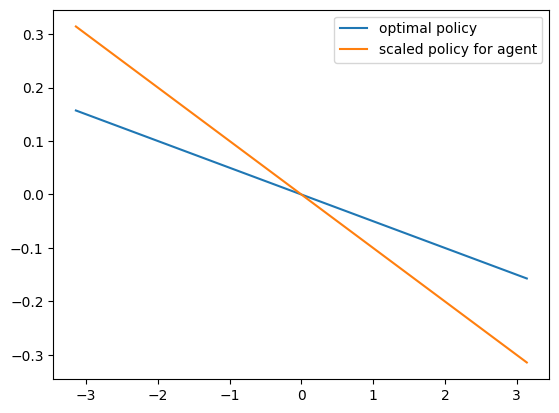

In [31]:
plt.plot(o_vals, ana_sum, label='optimal policy')
plt.plot(o_vals, ana_scaled, label='scaled policy for agent')
plt.legend()
plt.show()

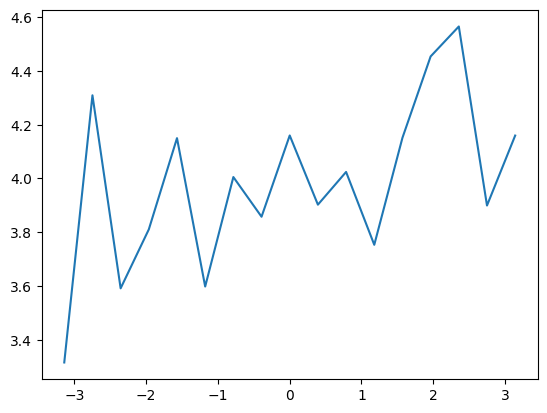

In [32]:
plt.plot(o_vals, rewards)
plt.show()

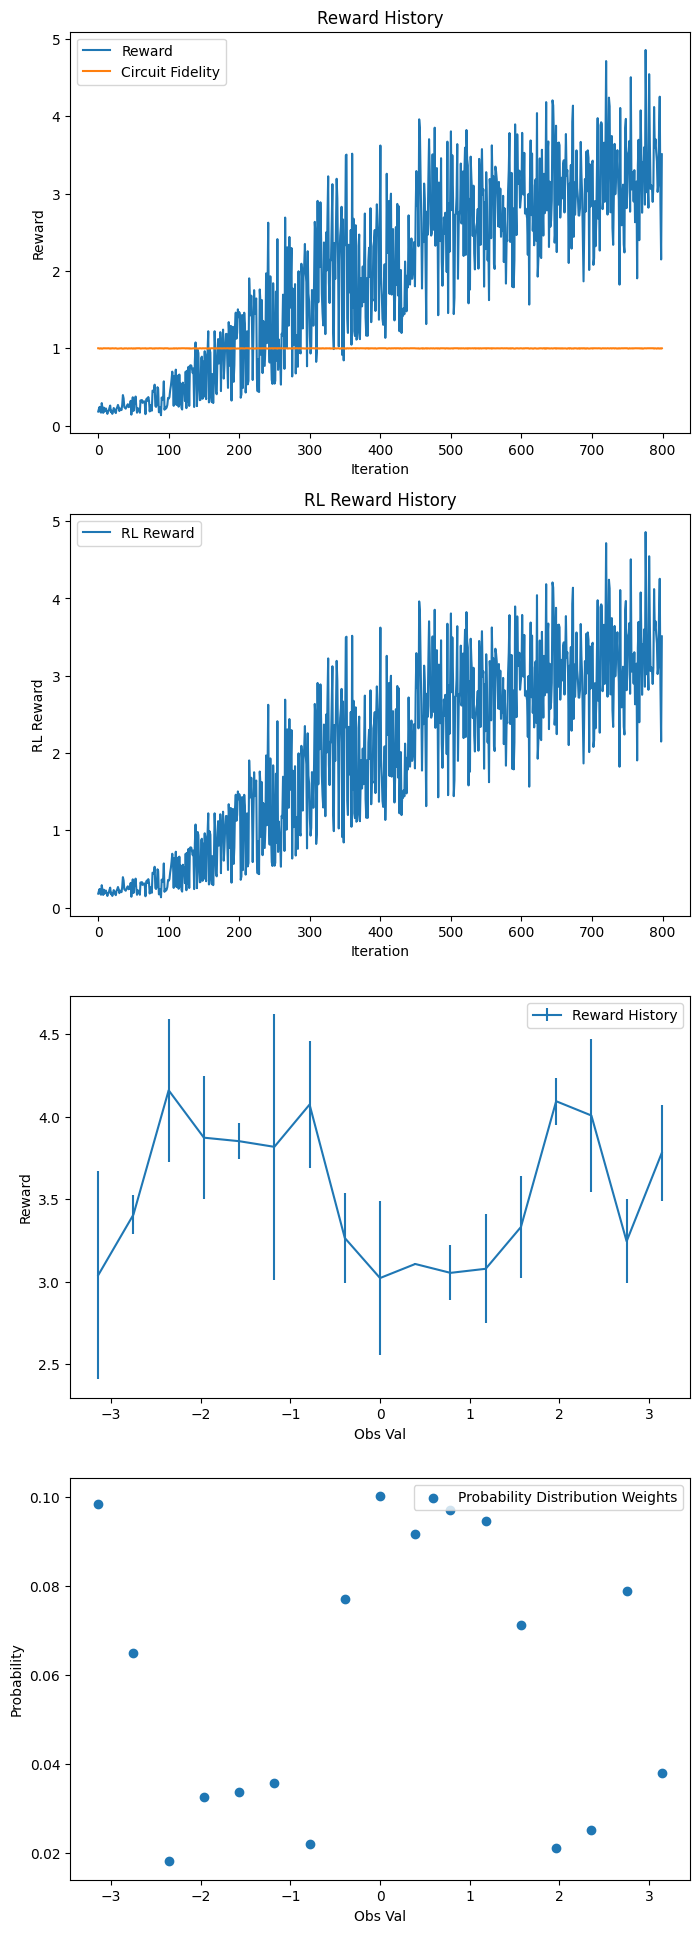

model saved to runs/PPO_CleanRL__Test PPO CleanRL__1__1742227385/Test PPO CleanRL.cleanrl_model


In [33]:
ppo_agent.env.unwrapped.clear_history()
# ppo_agent.env.clear_history()
ppo_agent.run_training()

In [44]:
# Visualizing Policy wrt actions

import torch

full_actions = []
actions = []
std_actions = []

for sample_obs in ppo_agent.env.unwrapped.discrete_obs_vals:
    next_obs = torch.Tensor(np.tile(sample_obs / np.pi, (ppo_agent.num_envs, 1)))
    action, logprob, _, value = ppo_agent.agent.get_action_and_value(
        next_obs
    )
    cpu_action = action.cpu().numpy()
    cpu_action = np.clip(
        cpu_action,
        -1,
        1.
        # ppo_agent.env.action_space.low,
        # ppo_agent.env.action_space.high,
    )
    # cpu_action *= 0.5
    full_actions.append(cpu_action)
    actions.append(np.mean(cpu_action, axis=0))
    std_actions.append(np.std(cpu_action, axis=0))

In [45]:
print(std_actions)

[array([0.02237718, 0.        , 0.        , 0.01522442, 0.03059888,
       0.0287297 , 0.03275445], dtype=float32), array([0.02020668, 0.        , 0.        , 0.0158689 , 0.03834801,
       0.03657703, 0.02342735], dtype=float32), array([0.01313289, 0.        , 0.        , 0.0142106 , 0.03213391,
       0.02844924, 0.0283769 ], dtype=float32), array([0.02281413, 0.        , 0.        , 0.01826465, 0.03837783,
       0.03748882, 0.02238676], dtype=float32), array([0.02104566, 0.        , 0.        , 0.01804293, 0.03333639,
       0.03571886, 0.02829917], dtype=float32), array([0.01838558, 0.        , 0.        , 0.01193856, 0.03277231,
       0.03762925, 0.02811437], dtype=float32), array([0.01741319, 0.        , 0.        , 0.01410537, 0.03531944,
       0.03389704, 0.03853678], dtype=float32), array([0.01694905, 0.        , 0.        , 0.01538873, 0.0323986 ,
       0.03225147, 0.0249416 ], dtype=float32), array([0.01816215, 0.04687254, 0.0432415 , 0.01738619, 0.03261729,
       0.028

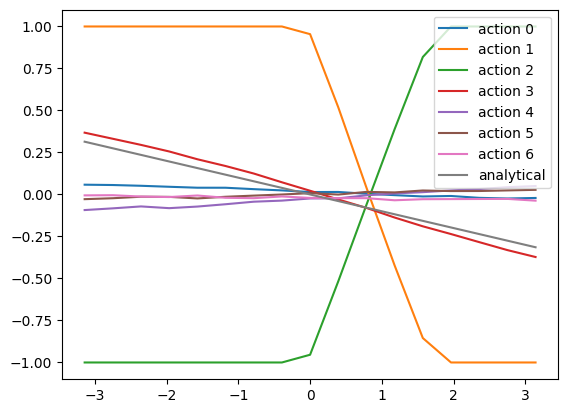

In [48]:
actions = np.array(actions)

o_vals = ppo_agent.env.unwrapped.discrete_obs_vals
ana_sum = -o_vals * 0.05 / 0.5

for i in range(len(actions[0])):
    plt.plot(o_vals, actions[:,i], label=f'action {i}')
# plt.plot(o_vals, (actions[:,1] - actions[:,2]) * np.pi, label=f'sum')
plt.plot(o_vals, ana_sum, label=f'analytical')
plt.legend()
plt.show()

In [49]:
single_n_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=32,
        n_reps=[1,],
        n_shots=10,
        sampling_paulis=100,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="fidelity",
    env_metadata=env_metadata,
)

single_n_q_env = OneParamAngleSpilloverEnv(
    single_n_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix, 
    num_params=17,
    discrete_history_length=3,
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-5
)

Observation Vals: [-3.14159265 -2.74889357 -2.35619449 -1.96349541 -1.57079633 -1.17809725
 -0.78539816 -0.39269908  0.          0.39269908  0.78539816  1.17809725
  1.57079633  1.96349541  2.35619449  2.74889357  3.14159265]


In [50]:
# Testing fidelity of agents

import copy

rewards = []

action_test = copy.deepcopy(actions) * 0.5

for i, sample_obs in enumerate(ppo_agent.env.unwrapped.discrete_obs_vals):
    next_obs = torch.Tensor(np.tile(sample_obs, (ppo_agent.num_envs, 1)))

    _obs, info = single_n_q_env.reset(seed=ppo_agent.seed, debug_obs=np.array([sample_obs]))
    act = action_test[i]
    act[0] = 0.
    act[1] = 0.
    act[2] = 0.
    # act[3] = ana_sum[i]
    act[4] = 0.
    act[5] = 0.
    act[6] = 0.
    batch_action = np.tile(act, (alt_q_env.batch_size, 1))
    obs, reward, terminated, truncated, info = single_n_q_env.step(batch_action)
    rewards.append(np.mean(reward))

Sampled angles:  [ 0.          0.         -3.14159265  0.          0.          0.        ]
Environment Observation: [-1.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities:  0.9998556158545414
Reward (avg): 0.9998556158545414 Std: 0.0
obs: [-1.]
reward: [3.84048049 3.84048049 3.84048049 3.84048049 3.84048049 3.84048049
 3.84048049 3.84048049 3.84048049 3.84048049 3.84048049 3.84048049
 3.84048049 3.84048049 3.84048049 3.84048049 3.84048049 3.84048049
 3.84048049 3.84048049 3.84048049 3.84048049 3.84048049 3.84048049
 3.84048049 3.84048049 3.84048049 3.84048049 3.84048049 3.84048049
 3.84048049 3.84048049]
Sampled angles:  [ 0.          0.         -2.74889357  0.          0.          0.        ]
Environment Observation: [-0.875]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities:  0.9998392683841996
Reward (avg): 0.9998392683841996 Std: 0.0
obs: [-0.875]
reward: [3.793898

In [51]:
baseline_rewards = []

# action_test = copy.deepcopy(actions)

for i, sample_obs in enumerate(ppo_agent.env.unwrapped.discrete_obs_vals):
    next_obs = torch.Tensor(np.tile(sample_obs, (ppo_agent.num_envs, 1)))

    _obs, info = single_n_q_env.reset(seed=ppo_agent.seed, debug_obs=np.array([sample_obs]))
    act = action_test[i]
    act[0] = 0.
    act[1] = 0.
    act[2] = 0.
    act[3] = 0.
    act[4] = 0.
    act[5] = 0.
    act[6] = 0.
    batch_action = np.tile(act, (alt_q_env.batch_size, 1))
    obs, reward, terminated, truncated, info = single_n_q_env.step(batch_action)
    baseline_rewards.append(np.mean(reward))

Sampled angles:  [ 0.          0.         -3.14159265  0.          0.          0.        ]
Environment Observation: [-1.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities:  0.9950753362380551
Reward (avg): 0.9950753362380551 Std: 0.0
obs: [-1.]
reward: [2.30762342 2.30762342 2.30762342 2.30762342 2.30762342 2.30762342
 2.30762342 2.30762342 2.30762342 2.30762342 2.30762342 2.30762342
 2.30762342 2.30762342 2.30762342 2.30762342 2.30762342 2.30762342
 2.30762342 2.30762342 2.30762342 2.30762342 2.30762342 2.30762342
 2.30762342 2.30762342 2.30762342 2.30762342 2.30762342 2.30762342
 2.30762342 2.30762342]
Sampled angles:  [ 0.          0.         -2.74889357  0.          0.          0.        ]
Environment Observation: [-0.875]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities:  0.9962277361774309
Reward (avg): 0.9962277361774309 Std: 0.0
obs: [-0.875]
reward: [2.423397

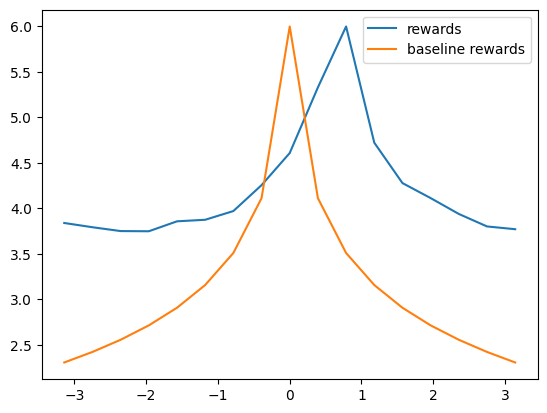

In [52]:
plt.plot(single_n_q_env.discrete_obs_vals, rewards, label='rewards')
plt.plot(single_n_q_env.discrete_obs_vals, baseline_rewards, label='baseline rewards')
plt.legend()
plt.show()

In [60]:
# Testing baseline vs optimal fidelities

from torch import Tensor

fidelity_history = []
baseline_history = []
n_angles = 100
phi_array = np.zeros((n_angles, len(q_env.circuit_parameters)))
actions_array = np.zeros((n_angles, 7))


for i in range(n_angles):
    obs, info = ppo_agent.env.reset()
    next_obs = torch.Tensor(np.tile(obs, (ppo_agent.num_envs, 1)))

    action, logprob, _, value = ppo_agent.agent.get_action_and_value(
        next_obs
    )
    cpu_action = action.cpu().numpy()
    actions_array[i] = np.mean(cpu_action, axis=0)
    phi_array[i] = obs
    # cpu_action = np.clip(
    #     cpu_action,
    #     -1,
    #     1.
    #     # ppo_agent.env.action_space.low,
    #     # ppo_agent.env.action_space.high,
    # )

Sampled angles:  [ 0.          0.         -1.57079633  0.          0.          0.        ]
Environment Observation: [-0.5]
Sampled angles:  [0.         0.         1.17809725 0.         0.         0.        ]
Environment Observation: [0.375]
Sampled angles:  [0.         0.         0.78539816 0.         0.         0.        ]
Environment Observation: [0.25]
Sampled angles:  [0.         0.         1.17809725 0.         0.         0.        ]
Environment Observation: [0.375]
Sampled angles:  [0.         0.         2.74889357 0.         0.         0.        ]
Environment Observation: [0.875]
Sampled angles:  [ 0.          0.         -1.17809725  0.          0.          0.        ]
Environment Observation: [-0.375]
Sampled angles:  [0.         0.         1.57079633 0.         0.         0.        ]
Environment Observation: [0.5]
Sampled angles:  [0.         0.         0.78539816 0.         0.         0.        ]
Environment Observation: [0.25]
Sampled angles:  [0. 0. 0. 0. 0. 0.]
Environment

In [61]:
print(phi_array)
print(actions_array)

[[-0.5   -0.5   -0.5   -0.5   -0.5   -0.5  ]
 [ 0.375  0.375  0.375  0.375  0.375  0.375]
 [ 0.25   0.25   0.25   0.25   0.25   0.25 ]
 [ 0.375  0.375  0.375  0.375  0.375  0.375]
 [ 0.875  0.875  0.875  0.875  0.875  0.875]
 [-0.375 -0.375 -0.375 -0.375 -0.375 -0.375]
 [ 0.5    0.5    0.5    0.5    0.5    0.5  ]
 [ 0.25   0.25   0.25   0.25   0.25   0.25 ]
 [ 0.     0.     0.     0.     0.     0.   ]
 [ 0.75   0.75   0.75   0.75   0.75   0.75 ]
 [ 0.625  0.625  0.625  0.625  0.625  0.625]
 [-0.125 -0.125 -0.125 -0.125 -0.125 -0.125]
 [ 0.     0.     0.     0.     0.     0.   ]
 [ 0.625  0.625  0.625  0.625  0.625  0.625]
 [-0.875 -0.875 -0.875 -0.875 -0.875 -0.875]
 [-0.625 -0.625 -0.625 -0.625 -0.625 -0.625]
 [-0.125 -0.125 -0.125 -0.125 -0.125 -0.125]
 [ 0.25   0.25   0.25   0.25   0.25   0.25 ]
 [-0.5   -0.5   -0.5   -0.5   -0.5   -0.5  ]
 [ 0.5    0.5    0.5    0.5    0.5    0.5  ]
 [ 0.125  0.125  0.125  0.125  0.125  0.125]
 [-0.25  -0.25  -0.25  -0.25  -0.25  -0.25 ]
 [ 0.     

In [62]:
rewards = []

action_test = copy.deepcopy(actions_array) * 0.5
policy_rewards = []

for i in range(n_angles):
    next_obs = torch.Tensor(np.tile(phi_array[i], (ppo_agent.num_envs, 1)))

    _obs, info = single_n_q_env.reset(seed=ppo_agent.seed, debug_obs=np.array([sample_obs]))
    act = action_test[i]
    act[0] = 0.
    act[1] = 0.
    act[2] = 0.
    # act[3] = ana_sum[i]
    act[4] = 0.
    act[5] = 0.
    act[6] = 0.
    batch_action = np.tile(act, (alt_q_env.batch_size, 1))
    obs, reward, terminated, truncated, info = single_n_q_env.step(batch_action)
    policy_rewards.append(np.mean(reward))

Sampled angles:  [0.         0.         3.14159265 0.         0.         0.        ]
Environment Observation: [1.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities:  0.9864838973113066
Reward (avg): 0.9864838973113066 Std: 0.0
obs: [1.]
reward: [1.86914852 1.86914852 1.86914852 1.86914852 1.86914852 1.86914852
 1.86914852 1.86914852 1.86914852 1.86914852 1.86914852 1.86914852
 1.86914852 1.86914852 1.86914852 1.86914852 1.86914852 1.86914852
 1.86914852 1.86914852 1.86914852 1.86914852 1.86914852 1.86914852
 1.86914852 1.86914852 1.86914852 1.86914852 1.86914852 1.86914852
 1.86914852 1.86914852]
Sampled angles:  [0.         0.         3.14159265 0.         0.         0.        ]
Environment Observation: [1.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities:  0.9984412067689521
Reward (avg): 0.9984412067689521 Std: 0.0
obs: [1.]
reward: [2.80721149 2.80721149 2.807211

In [ ]:
rewards = []

action_test = copy.deepcopy(actions_array) * 0.5
baseline_rewards = []

for i in range(n_angles):
    next_obs = torch.Tensor(np.tile(phi_array[i], (ppo_agent.num_envs, 1)))

    _obs, info = single_n_q_env.reset(seed=ppo_agent.seed, debug_obs=np.array([sample_obs]))
    act = action_test[i]
    act[0] = 0.
    act[1] = 0.
    act[2] = 0.
    act[3] = 0.
    act[4] = 0.
    act[5] = 0.
    act[6] = 0.
    batch_action = np.tile(act, (alt_q_env.batch_size, 1))
    obs, reward, terminated, truncated, info = single_n_q_env.step(batch_action)
    baseline_rewards.append(np.mean(reward))